In [1]:
!pip install prophet

In [2]:
# Import Libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import datetime
import math
import warnings
import prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore")

In [3]:
# import and display csv file
df = pd.read_csv('AAPL.csv')
df.head()

Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100323  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095089  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088110  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090291   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092908   73449600

In [4]:
# display bottom rows of csv file
df.tail()

Date        Open        High         Low       Close   Adj Close  \
10404  2022-03-18  160.509995  164.479996  159.759995  163.979996  163.979996   
10405  2022-03-21  163.509995  166.350006  163.009995  165.380005  165.380005   
10406  2022-03-22  165.509995  169.419998  164.910004  168.820007  168.820007   
10407  2022-03-23  167.990005  172.639999  167.649994  170.210007  170.210007   
10408  2022-03-24  171.059998  174.139999  170.210007  174.070007  174.070007   

          Volume  
10404  123351200  
10405   95811400  
10406   81532000  
10407   98062700  
10408   90018700

In [5]:
# checking shape of dataframe
df.shape

(10409, 7)

In [6]:
#checking data types of data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [7]:
#renaming columns to python casing.
col_head = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Close': 'close',
    'Low': 'low',
    'Adj Close': 'adj_close',
    'Volume': 'volume'}
df.rename(columns=col_head, inplace=True)

In [8]:
# checking for NULL values
print("Null Values:\n", df.isna().sum())
 
# dropping null values
df = df.dropna()
 
# verifying null values were dropped
print("Null Values after dropping:\n", df.isna().sum())

Null Values:
 date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64
Null Values after dropping:
 date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64


In [9]:
# checking for duplicate values
print("Duplicate Values:\n", df.duplicated().sum())
 
# dropping duplicate values
df = df.drop_duplicates()
 
# verifying duplicates were dropped
print("Duplicate Values after dropping:\n", df.duplicated().sum())

Duplicate Values:
 0
Duplicate Values after dropping:
 0


In [10]:
# printing summary statistics
df.describe()

open          high           low         close     adj_close  \
count  10409.000000  10409.000000  10409.000000  10409.000000  10409.000000   
mean      13.959910     14.111936     13.809163     13.966757     13.350337   
std       30.169244     30.514878     29.835055     30.191696     29.911132   
min        0.049665      0.049665      0.049107      0.049107      0.038384   
25%        0.281964      0.287946      0.274554      0.281250      0.234799   
50%        0.468750      0.477679      0.459821      0.468750      0.386853   
75%       14.217857     14.364286     14.043571     14.206071     12.188149   
max      182.630005    182.940002    179.119995    182.009995    181.778397   

             volume  
count  1.040900e+04  
mean   3.321778e+08  
std    3.393344e+08  
min    0.000000e+00  
25%    1.247604e+08  
50%    2.199680e+08  
75%    4.126108e+08  
max    7.421641e+09

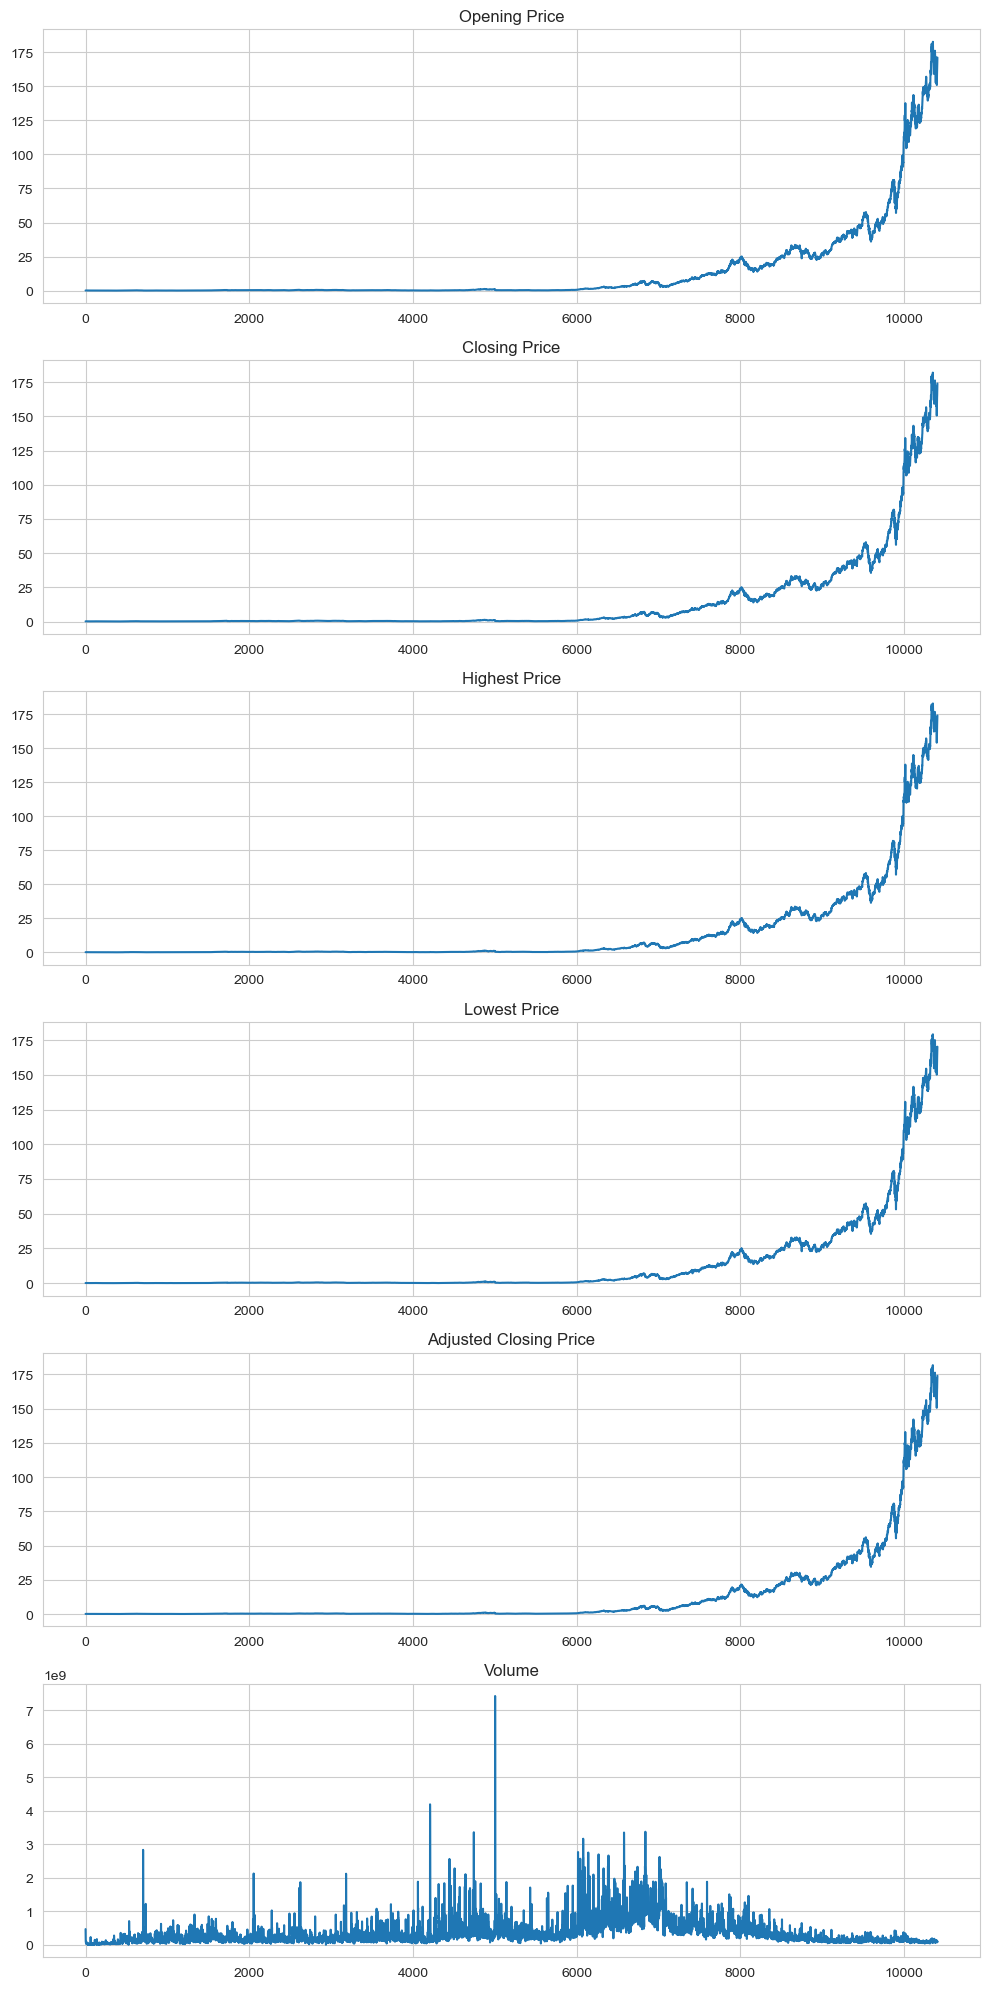

In [11]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))

# plot each trace on the corresponding subplot
axs[0].plot(df.index, df["open"])
axs[0].set_title("Opening Price")
axs[1].plot(df.index, df["close"])
axs[1].set_title("Closing Price")
axs[2].plot(df.index, df["high"])
axs[2].set_title("Highest Price")
axs[3].plot(df.index, df["low"])
axs[3].set_title("Lowest Price")
axs[4].plot(df.index, df["adj_close"])
axs[4].set_title("Adjusted Closing Price")
axs[5].plot(df.index, df["volume"])
axs[5].set_title("Volume")

# Adjust layout
plt.tight_layout()

In [12]:
# duplicate the date column
df['date_duplicate'] = df['date']

# index on date
df.set_index('date', inplace=True)

In [13]:
# importing plotly for an interactive graph
import plotly.graph_objects as go
import plotly.express as px

# create a figure
fig = px.line(df, x=df.index, y=['open', 'high', 'low', 'close'], title='Apple Stock Price 1980-2022')

# add labels
fig.update_layout(xaxis_title='date', yaxis_title='Price (USD)')

# show the interactive plot
fig.show()

In [14]:
# calculate the moving average
moving_avg = df['close'].rolling(window=100).mean()

# create a figure
fig = go.Figure()

# add the moving average trace
fig.add_trace(go.Scatter(x=df.index, y=moving_avg, mode='lines', name='Simple Moving Average'))

# add the closing price trace
fig.add_trace(go.Scatter(x=df.index, y=df["close"], mode='lines', name='Closing Price'))

# update layout
fig.update_layout(title='Moving Average of Closing Price',
                  xaxis_title='date',
                  yaxis_title='Price (USD)',
                  xaxis=dict(tickangle=-45),
                  showlegend=True)

# show the plot
fig.show()

In [15]:
# create subset data frame that contains just the date and close column
df_close = df[['close']]
df_close.reset_index(inplace=True)
df_close.head()

date     close
0  1980-12-12  0.128348
1  1980-12-15  0.121652
2  1980-12-16  0.112723
3  1980-12-17  0.115513
4  1980-12-18  0.118862

In [16]:
# updating column names to the Prophet casing convention
df_new = df_close.rename(mapper={"date": "ds", "close": "y"}, axis="columns")
df_new.head()

ds         y
0  1980-12-12  0.128348
1  1980-12-15  0.121652
2  1980-12-16  0.112723
3  1980-12-17  0.115513
4  1980-12-18  0.118862

In [17]:
# training and forecasting the model using Facebook prophet model
op = prophet.Prophet()
op.fit(df_new)
forecast = op.make_future_dataframe(periods=365)
forecast = op.predict(forecast)

18:57:21 - cmdstanpy - INFO - Chain [1] start processing
18:57:29 - cmdstanpy - INFO - Chain [1] done processing


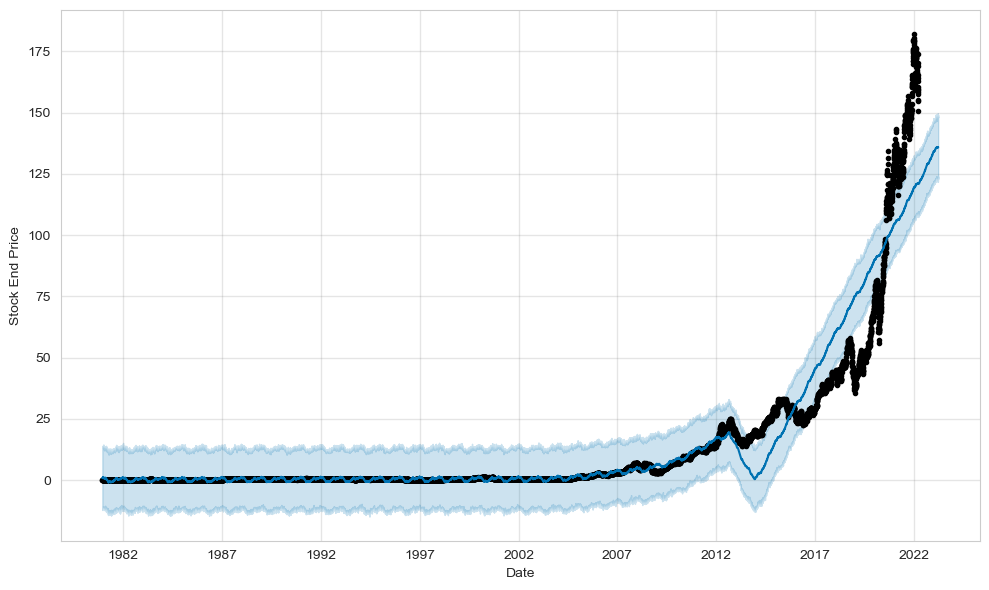

In [18]:
# visualizing forecast results
op.plot(forecast, xlabel="Date", ylabel="Stock End Price")
plt.show()

In [19]:
# first forecast was poor, removing data prior to 2015
df_new['ds'] = pd.to_datetime(df_new['ds'])
df_new = df_new[df_new['ds'].dt.year >= 2015]

In [20]:
df_new

ds           y
8589  2015-01-02   27.332500
8590  2015-01-05   26.562500
8591  2015-01-06   26.565001
8592  2015-01-07   26.937500
8593  2015-01-08   27.972500
...          ...         ...
10404 2022-03-18  163.979996
10405 2022-03-21  165.380005
10406 2022-03-22  168.820007
10407 2022-03-23  170.210007
10408 2022-03-24  174.070007

[1820 rows x 2 columns]

In [21]:
# training and forecasting the model using Facebook prophet model
op = prophet.Prophet()
op.fit(df_new)
forecast = op.make_future_dataframe(periods=365)
forecast = op.predict(forecast)

18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# visualizing second forecast results
op.plot(forecast, xlabel="Date", ylabel="Stock End Price")
plt.show()

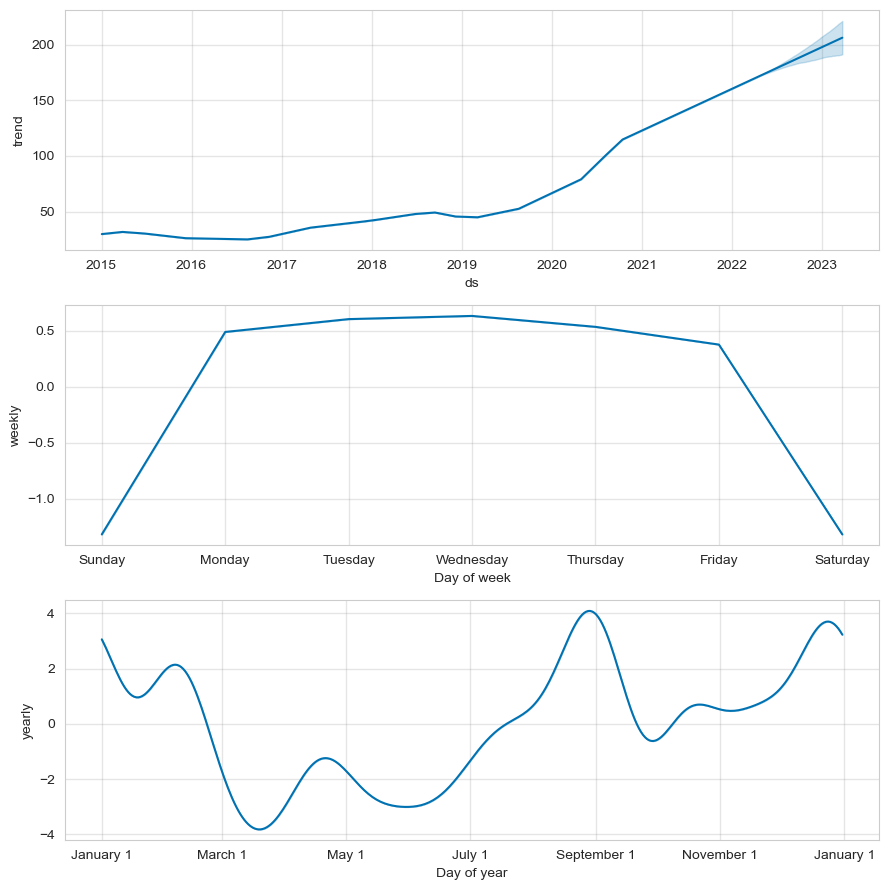

In [23]:
# Plot the components of the forecast
fig = op.plot_components(forecast)
plt.show()

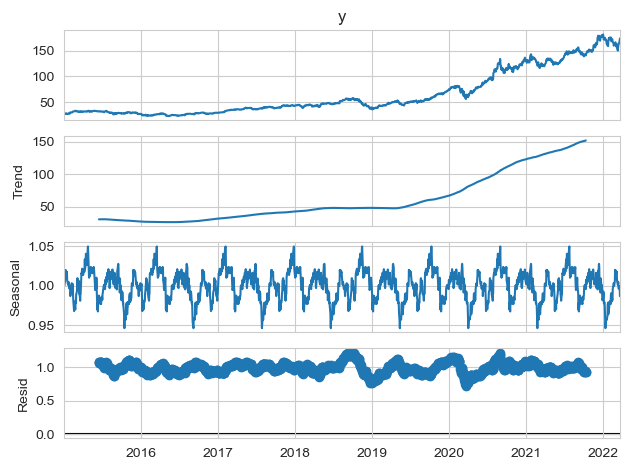

In [24]:
# import seasonal decompose from statsmodels library
from statsmodels.tsa.seasonal import seasonal_decompose

# index on date
df_new.set_index("ds", inplace=True)

# Decomposition
result = seasonal_decompose(df_new.y, model='multiplicative', period=225)

# Plot Trend, Seasonality, Residuals
result.plot()
plt.show()

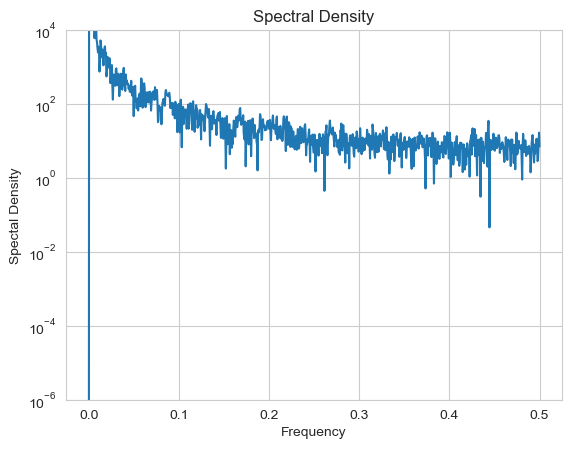

In [25]:
import matplotlib.gridspec as gridspec

# Power spectral density
from scipy import signal
f, Pxx_den = signal.periodogram(df_new['y'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e4])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

In [26]:
# updating the range of values for analysis due to the poor forecast with the prophet model
df_close['date'] = pd.to_datetime(df_close['date'])
df_close = df_close[df_close['date'].dt.year >= 2015]

# index on date
df_close.set_index('date', inplace=True)

# Print the shape of the filtered DataFrame
print(df_close.shape)

(1820, 1)


In [27]:
df_close.head()

close
date                 
2015-01-02  27.332500
2015-01-05  26.562500
2015-01-06  26.565001
2015-01-07  26.937500
2015-01-08  27.972500

In [28]:
df_close.tail()

close
date                  
2022-03-18  163.979996
2022-03-21  165.380005
2022-03-22  168.820007
2022-03-23  170.210007
2022-03-24  174.070007

In [29]:
# splitting the data into training and testing sets 80/20 split
X_train = df_close[:1456]
X_test = df_close[1456:]

# print the shape of the datasets
print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (1456, 1)
X_test Shape (364, 1)


In [30]:
# creating forecast for next twelve months
fy_forecast = pd.date_range(start='2022-03-27', end='2023-03-31', freq='B')
fy_forecast

DatetimeIndex(['2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
               '2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06',
               '2022-04-07', '2022-04-08',
               ...
               '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23',
               '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29',
               '2023-03-30', '2023-03-31'],
              dtype='datetime64[ns]', length=265, freq='B')

In [31]:
# performing ADF test to check for stationarity
def define_d(data):
    adf_result = adfuller(data, autolag="AIC")
    adf_statistic = adf_result[0]
    pvalue = adf_result[1]
    critical_value = adf_result[4]["5%"]
    
    print(f"ADF Test Statistic: {adf_statistic}")
    print(f"p-value: {pvalue}")
    print(f"Critical Value (5%): {critical_value}")
    
    if pvalue < 0.05:
        print("** Data is stationary, proceed to plotting ACF and PACF.**")
    else:
        print("** Data is not stationary, and needs to be differenced! **")

define_d(X_train)

ADF Test Statistic: 2.3635665531945196
p-value: 0.9989921192624683
Critical Value (5%): -2.863561857668172
** Data is not stationary, and needs to be differenced! **


In [32]:
# performing differencing to make data staionary
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic: -7.488965986870958
p-value: 4.5589820085980184e-11
Critical Value (5%): -2.863561857668172
** Data is stationary, proceed to plotting ACF and PACF.**


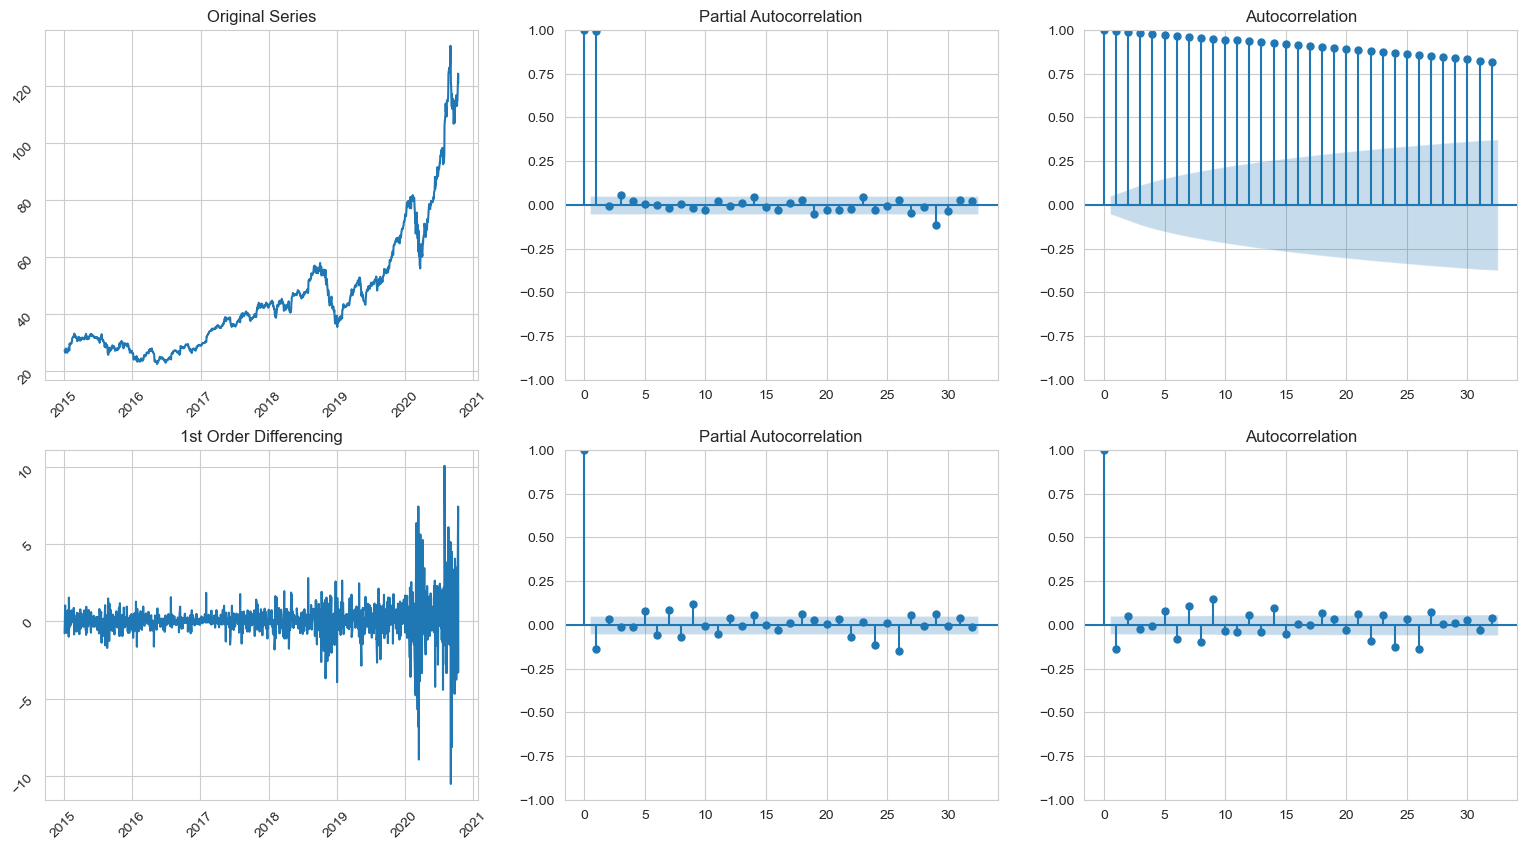

In [33]:
# Original dataframe visualization
fig, axes = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(19)
axes[0, 0].plot(X_train)
axes[0, 0].tick_params(labelrotation=45)
axes[0, 0].set_title("Original Series")
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# visualizing data post first differencing
axes[1, 0].plot(X_train.diff())
axes[1, 0].set_title("1st Order Differencing")
axes[1, 0].tick_params(labelrotation=45)
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show();

In [34]:
price_validate = df_close["close"][1456:]
price_validate

date
2020-10-14    121.190002
2020-10-15    120.709999
2020-10-16    119.019997
2020-10-19    115.980003
2020-10-20    117.510002
                 ...    
2022-03-18    163.979996
2022-03-21    165.380005
2022-03-22    168.820007
2022-03-23    170.210007
2022-03-24    174.070007
Name: close, Length: 364, dtype: float64

In [35]:
# calculating the Root Mean Squared Error (RMSE)
def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return {"Mean Absolute Percentage Error (%)": mape, "Root Mean Squared Error": rmse}

### Arima Model

In [36]:
model = ARIMA(X_train)
model = model.fit()
print(model.summary())

fc = model.forecast(364)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1456
Model:                          ARIMA   Log Likelihood               -6503.753
Date:                Sun, 03 Mar 2024   AIC                          13011.507
Time:                        18:57:53   BIC                          13022.074
Sample:                             0   HQIC                         13015.449
                               - 1456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.3707      0.857     52.959      0.000      43.692      47.050
sigma2       444.0009     16.194     27.417      0.000     412.260     475.741
Ljung-Box (L1) (Q):                1441.09   Jarque-

{'Mean Absolute Percentage Error (%)': 67.55,
 'Root Mean Squared Error': 98.41523686774337}

In [37]:
model = ARIMA(X_train, order=(1, 0, 1))
model = model.fit()
print(model.summary())

fc = model.forecast(364)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1456
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2251.763
Date:                Sun, 03 Mar 2024   AIC                           4511.525
Time:                        18:57:55   BIC                           4532.659
Sample:                             0   HQIC                          4519.410
                               - 1456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.2916    193.929      0.239      0.811    -333.802     426.385
ar.L1          0.9998      0.001   1292.451      0.000       0.998       1.001
ma.L1         -0.1219      0.011    -11.080      0.0

{'Mean Absolute Percentage Error (%)': 15.75,
 'Root Mean Squared Error': 30.536918644529457}

In [38]:
model = ARIMA(X_train, order=(1, 1, 1))
model = model.fit()
print(model.summary())

fc = model.forecast(364)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1456
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2244.252
Date:                Sun, 03 Mar 2024   AIC                           4494.504
Time:                        18:57:55   BIC                           4510.352
Sample:                             0   HQIC                          4500.417
                               - 1456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3705      0.067     -5.551      0.000      -0.501      -0.240
ma.L1          0.2398      0.070      3.413      0.001       0.102       0.377
sigma2         1.2802      0.014     90.495      0.0

{'Mean Absolute Percentage Error (%)': 13.94,
 'Root Mean Squared Error': 27.427856712866763}

    We must reject the null hypothesis as the ARIMA model at best runs with about 86% accuracy. (add to ppt)

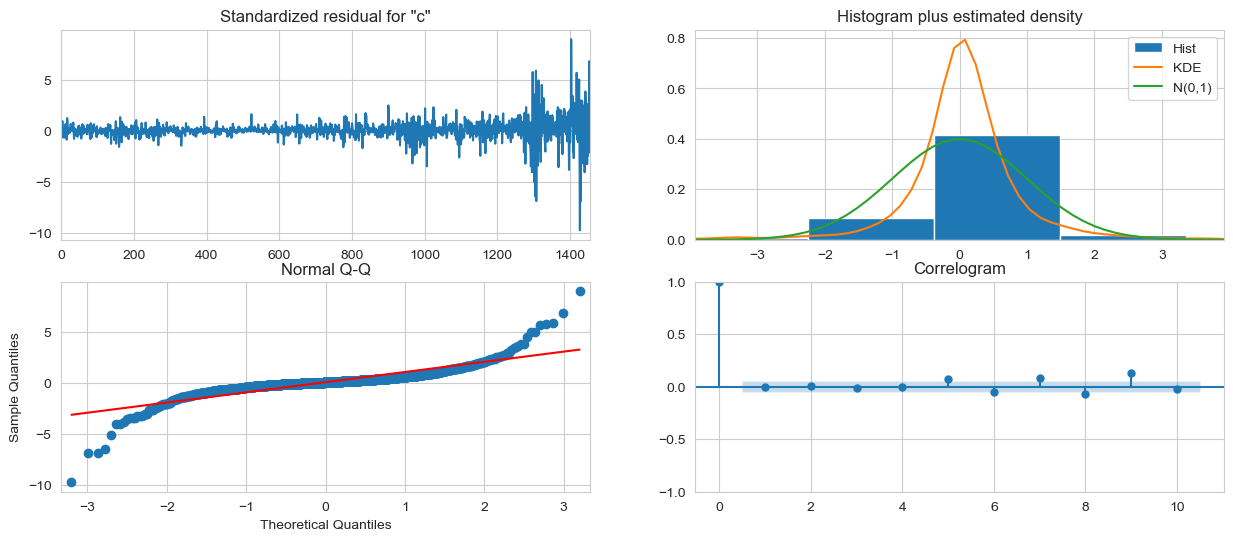

In [39]:
model.plot_diagnostics(figsize=(15,6))
plt.show()

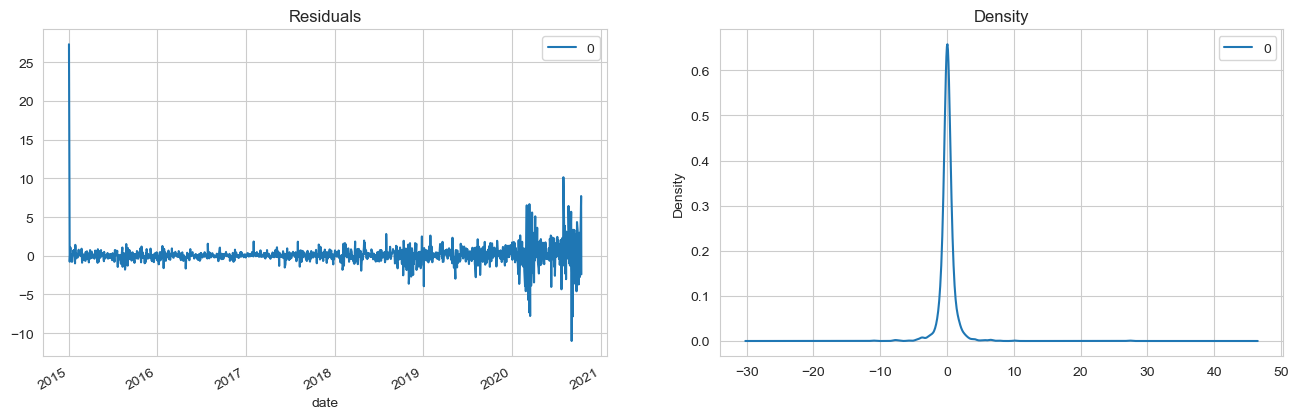

In [40]:
# plotting residuals and density
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(16)
residuals = pd.DataFrame(model.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind="kde", title="Density", ax=ax[1])
plt.show()

In [41]:
# Get the forecast and confidence intervals
forecast = model.get_forecast(steps=265)
conf_int = forecast.conf_int()

# Plot the actual data
plt.plot(df_close, label='Actual')

# Plot the forecasted data
plt.plot(fy_forecast, forecast.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(fy_forecast, conf_int['lower close'], conf_int['upper close'], color='pink', alpha=1)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecast with Confidence Interval')
plt.legend()
plt.show()

In [42]:
# printing forecasted values
forecast.predicted_mean

1456    121.747739
1457    121.507763
1458    121.596670
1459    121.563732
1460    121.575935
           ...    
1716    121.572636
1717    121.572636
1718    121.572636
1719    121.572636
1720    121.572636
Name: predicted_mean, Length: 265, dtype: float64

In [43]:
# printing lower and upper close values
conf_int

lower close  upper close
1456   119.530158   123.965319
1457   118.569453   124.446074
1458   118.022419   125.170920
1459   117.470262   125.657202
1460   117.015587   126.136282
...           ...          ...
1716    89.153415   153.991856
1717    89.091408   154.053863
1718    89.029519   154.115752
1719    88.967748   154.177523
1720    88.906094   154.239178

[265 rows x 2 columns]

In [44]:
price_forecast = model.forecast(265)
price_forecast = pd.Series(price_forecast, index=fy_forecast)
price_forecast = price_forecast.rename("Prediction")

fig, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(x="date", y="close", data=df_close, color="red", marker="^")
price_forecast.plot(ax=ax, c="green", marker="x", label="Prediction")
X_test.plot(ax=ax, c="blue", marker="^")
plt.title("Stock Price")
plt.legend(loc=0, fontsize=15)
plt.show()

In [45]:
# printing forecast predictions for next twelve months
df = pd.DataFrame({"Predictions": model.forecast(265)})
df["date"] = fy_forecast
df.set_index("date")

Predictions
date                   
2022-03-28   121.747739
2022-03-29   121.507763
2022-03-30   121.596670
2022-03-31   121.563732
2022-04-01   121.575935
...                 ...
2023-03-27   121.572636
2023-03-28   121.572636
2023-03-29   121.572636
2023-03-30   121.572636
2023-03-31   121.572636

[265 rows x 1 columns]

In [46]:
# splitting data into training and testing for an LTSM model
x_train, y_train = X_train.index, X_train.close
x_test, y_test = X_test.index, X_test.close

print(x_train.shape), print(x_test.shape)

(1456,)
(364,)


(None, None)

In [47]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# fitting the model on the testing data
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
)

Epoch 1/100

23/23 [==============================] - 17s 152ms/step - loss: 2488.2271 - val_loss: 20391.4785
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 2389.8928 - val_loss: 19729.4980
Epoch 3/100
23/23 [==============================] - 0s 16ms/step - loss: 2066.7595 - val_loss: 18423.7539
Epoch 4/100
23/23 [==============================] - 0s 16ms/step - loss: 1728.4023 - val_loss: 17512.5215
Epoch 5/100
23/23 [==============================] - 1s 24ms/step - loss: 1570.6234 - val_loss: 17094.6934
Epoch 6/100
23/23 [==============================] - 0s 18ms/step - loss: 1478.5668 - val_loss: 16775.2617
Epoch 7/100
23/23 [==============================] - 0s 15ms/step - loss: 1404.4604 - val_loss: 16488.0000
Epoch 8/100
23/23 [==============================] - 0s 16ms/step - loss: 1338.2981 - val_loss: 16225.3076
Epoch 9/100
23/23 [==============================] - 0s 16ms/step - loss: 1278.6005 - val_loss: 15977.4229
Epoch 10/100
23/23 [==============

In [50]:
# valdating the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

12/12 [==============================] - 0s 5ms/step
Training RMSE: 13.25826198280763
Test RMSE: 85.87167053654704


In [51]:
# print the first ten predicted values of training set
train_predict[:10]

array([[27.732014],
       [27.015966],
       [27.018288],
       [27.364407],
       [28.32883 ],
       [28.356846],
       [27.713383],
       [27.939337],
       [27.84148 ],
       [27.148308]], dtype=float32)